In [43]:
import calendar
import numpy as np
import pandas as pd
from datetime import datetime
from collections import defaultdict

from portwine.strategies import StrategyBase
from portwine.backtester import Backtester
from portwine.loaders import EODHDMarketDataLoader
from portwine.data.interface import DataInterface
from portwine.analyzers import (
    EquityDrawdownAnalyzer, 
    MonteCarloAnalyzer, 
    SeasonalityAnalyzer,
    PerformanceAttributionAnalyzer,
    RiskContributionAnalyzer,
    TrendFilterAnalyzer
)

class GlobalMarketRotationStrategy(StrategyBase):
    """
    Implements the 'Global Market Rotation Strategy' described in:
      "A Global Market Rotation Strategy With An Annual Performance Of 41.4% Since 2003"

    ETFs involved:
      1) MDY  (US mid-cap stocks)
      2) IEV  (Europe)
      3) EEM  (Emerging Markets)
      4) ILF  (Latin America)
      5) EPP  (Asia-Pacific ex-Japan)
      6) EWJ  (Japan) - IMPORTANT: Added to capture Japan's distinct market cycles
      7) EDV  (Extended Duration Treasuries, used as 'risk-off' in market corrections)
      8) SHY  (Short-term Treasuries, used as a fallback 'cash' if EDV stops working)

    Core Logic (Monthly Rotation):
      • Once a month (near month-end or a chosen day), calculate a “score” (default: 3-month total return)
        for each of the 5 equity-region ETFs plus EDV. If, for some reason, EDV is not performing 
        or is not negatively correlated with equities, we can include SHY as a backup. 
      • Pick the top-ranked ETF and allocate 100% to it for the coming month.
      • Repeat each month.

    Simpler Variation:
      The paper says you can do well just by picking the best 3-month performer out of [MDY, IEV, EEM, ILF, EPP, EDV].
      Some traders also incorporate short-term Treasuries (SHY) if EDV fails to be a true safe haven.

    This example code:
      1) Rebalances monthly on the last trading day of each month.
      2) Ranks each ETF by its 3-month total return (63 trading days). 
      3) Optionally penalizes EDV for higher volatility (the paper suggests factoring in volatility),
         but here we keep it simple and rank purely by total return unless you choose otherwise.
      4) If EDV is the top pick, we invest in EDV. If for some reason EDV doesn’t have valid data
         (or you prefer correlation checks), you can skip or allow SHY as a fallback.

    Usage:
      strategy = GlobalMarketRotationStrategy(
          tickers=["MDY","IEV","EEM","ILF","EPP","EWJ","EDV","SHY"]
      )
      results = backtester.run_backtest(strategy, benchmark="SPY")
    """

    def __init__(
        self,
        tickers,
        lookback_days=63,
        rebalance_on_last_day=True,
        f_vol=0.0,
    ):
        """
        Parameters
        ----------
        tickers : list of str
            The set of ETFs to rotate among. Recommended:
              ["MDY","IEV","EEM","ILF","EPP","EWJ","EDV","SHY"].
            Note: EWJ (Japan) is recommended for better global coverage and alpha generation.
            Or omit "SHY" if you prefer just [MDY,IEV,EEM,ILF,EPP,EWJ,EDV].
        lookback_days : int
            The approximate 3-month lookback window (63 trading days).
        rebalance_on_last_day : bool
            If True, rebalance on the *last* trading day each month. 
            If False, you might choose a different approach. 
        f_vol : float
            (Optional) If > 0, we reduce each ETF's score by a factor of volatility 
            (similar to a Sharpe-like ranking). 
            For example, score = 3mo_return / (vol^f_vol).
            The paper does something like a small penalty for EDV’s higher volatility.
        """
        super().__init__(tickers)
        self.lookback_days = lookback_days
        self.rebalance_on_last_day = rebalance_on_last_day
        self.f_vol = f_vol

        # Price history for each ticker
        self.price_history = {tkr: [] for tkr in tickers}

        # Current daily weights
        self.current_weights = {tkr: 0.0 for tkr in tickers}

    def step(self, current_date, daily_data):
        """
        Called each trading day. 
          1) Store today's close in rolling buffers.
          2) Check if it's the end of the month (or monthly rebal day).
          3) If yes, rank all tickers by 3-month total return (plus optional volatility penalty),
             pick the top, and set that ticker's weight=1.0, all others=0.
        Returns
        -------
        dict : { ticker : float weight, ... }
        """
        # 1) Update rolling price data
        self._update_price_history(daily_data)

        # 2) If it's our monthly rebalance day, do the rotation
        if self._is_monthly_rebalance_day(current_date):
            best_ticker, best_score = None, float('-inf')

            for tkr in self.tickers:
                score = self._compute_score(tkr)
                if score is not None and score > best_score:
                    best_score = score
                    best_ticker = tkr

            # If we found a valid best ticker
            if best_ticker is not None:
                for tkr in self.tickers:
                    self.current_weights[tkr] = 1.0 if tkr == best_ticker else 0.0

        return dict(self.current_weights)

    def _update_price_history(self, daily_data):
        """Append today's close for each ticker; keep a reasonable buffer."""
        max_keep = self.lookback_days * 2  # just some buffer
        for tkr in self.price_history:
            if tkr in daily_data and daily_data[tkr] is not None:
                self.price_history[tkr].append(daily_data[tkr]['close'])
            else:
                self.price_history[tkr].append(np.nan)

            if len(self.price_history[tkr]) > max_keep:
                self.price_history[tkr].pop(0)

    def _is_monthly_rebalance_day(self, date):
        """
        If rebalance_on_last_day=True => check if date is the last trading day of its month.
        Otherwise, you could define a different rule (like day-of-month == some day).
        """
        if not self.rebalance_on_last_day:
            # Example: Rebalance on day-of-month=1
            return (date.day == 1)
        # Else if it's the last day of the month
        # Use calendar.monthrange to find last day
        last_day = calendar.monthrange(date.year, date.month)[1]
        return (date.day == last_day)

    def _compute_score(self, ticker):
        """
        We compute 3-month total return for this ticker. Then optionally 
        incorporate a volatility penalty if self.f_vol>0. 
        If not enough data, return None.
        """
        hist = self.price_history[ticker]
        if len(hist) < (self.lookback_days + 1):
            return None  # not enough data

        # Grab the last (lookback_days+1) prices, ignoring any NaNs inside
        recent = hist[-(self.lookback_days + 1):]
        # Filter out NaNs
        clean = [p for p in recent if not np.isnan(p)]
        if len(clean) < (self.lookback_days + 1):
            return None  # missing data

        start_price = clean[0]
        end_price = clean[-1]
        if start_price < 1e-9:
            return None

        # 3-month total return
        total_ret = (end_price / start_price) - 1.0

        if self.f_vol <= 0.0:
            # Simple approach: just use total_ret as score
            return total_ret
        else:
            # If we want to penalize volatility in a Sharpe-like sense:
            # daily returns over the same window
            daily_r = np.diff(clean) / np.array(clean[:-1])
            vol = np.std(daily_r, ddof=1)
            if vol < 1e-9:
                return None

            # Score = total_ret / (vol^f_vol)
            return total_ret / (vol ** self.f_vol)


In [ ]:
data_loader = EODHDMarketDataLoader(api_key='MY_KEY.06044651')
data_interface = DataInterface(data_loader)
backtester = Backtester(data_interface)

In [45]:
base_etfs = ["MDY", "IEV", "EEM", "ILF", "EPP", "EWJ", "EDV", "SHY"]  # Added EWJ (Japan) - was missing from original strategy

sector_etfs = ["XLP", "XLY", "XLF", "XLV", "XLK", "TLT", "SHY"]
broad_etfs = ["SPY", "QQQ", "IWM", "EFA", "EEM", "TLT", "SHV"]
commodity_etfs = ["GLD", "SLV", "USO", "DBA", "TLT", "SHY"]
stocks_basket = ["AAPL", "TSLA", "XOM", "JNJ", "TLT", "BIL"]
extended_sectors = ["XLF", "XLE", "XLK", "XLY", "XLP", "XLV", "XLI", "XLB", "XLU", "TLT", "SHY"]

Backtest: 100%|██████████| 250/250 [00:00<00:00, 2166.60it/s]


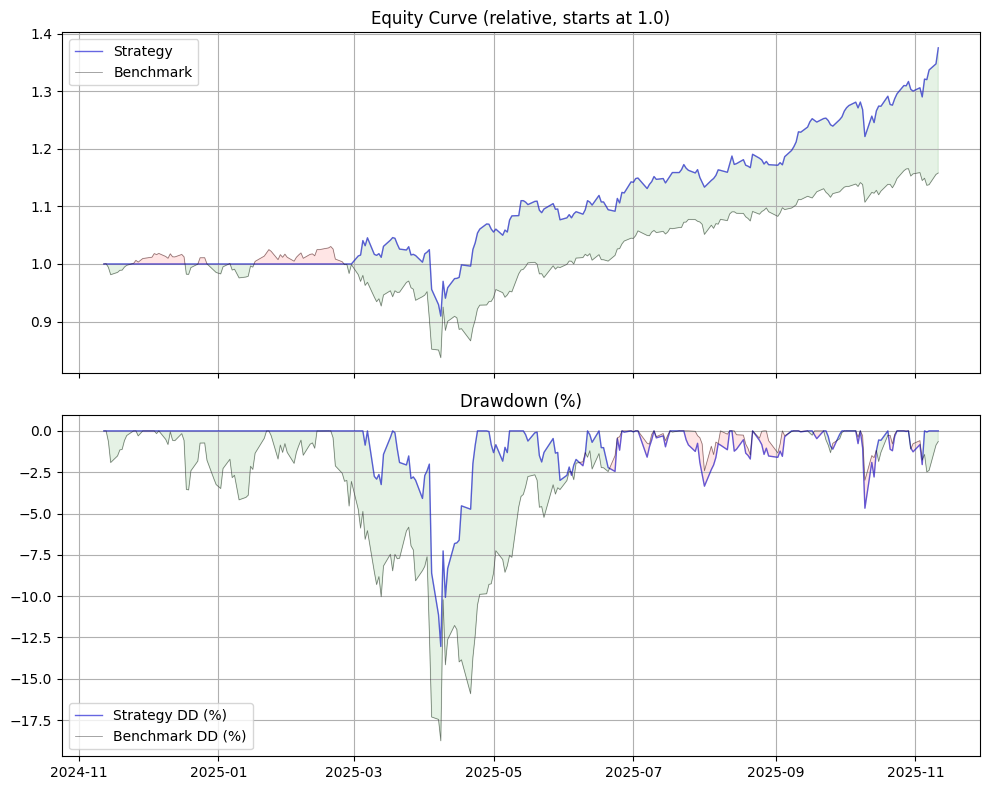

In [46]:
strategy = GlobalMarketRotationStrategy(
    tickers=base_etfs,
    lookback_days=63,
)
results_base = backtester.run_backtest(strategy, benchmark="SPY", verbose=True)

EquityDrawdownAnalyzer().plot(results_base)

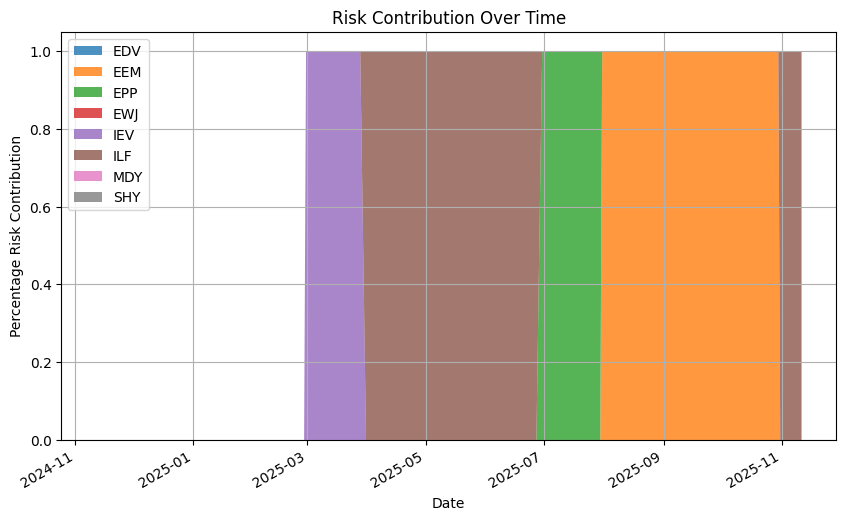

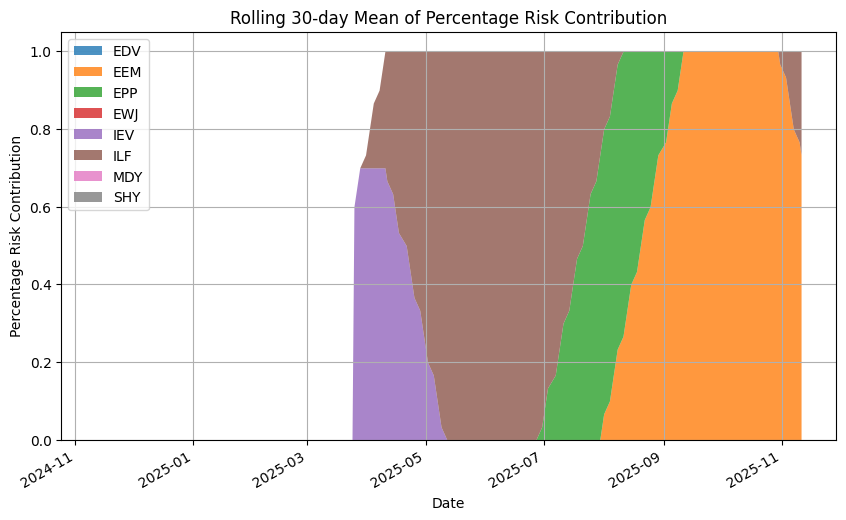

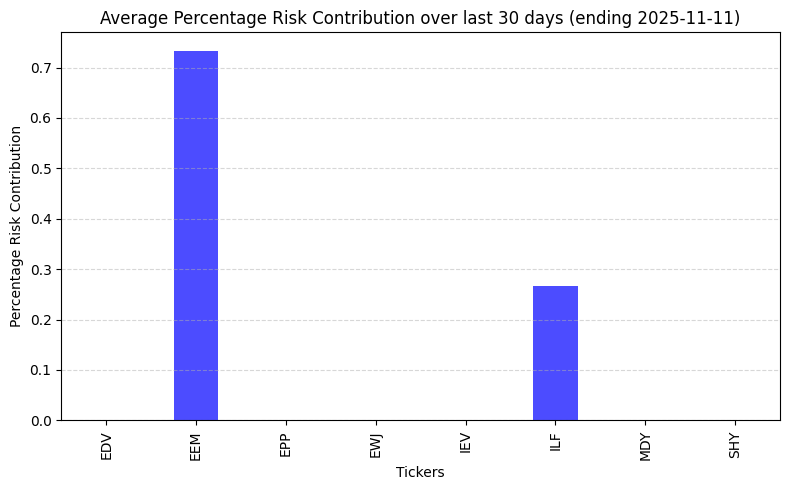

/Users/poboisvert/Desktop/GIT/portwine/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/poboisvert/Desktop/GIT/portwine/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/poboisvert/Desktop/GIT/portwine/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/poboisvert/Desktop/GIT/portwine/examples/risk_contribution_visualization.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


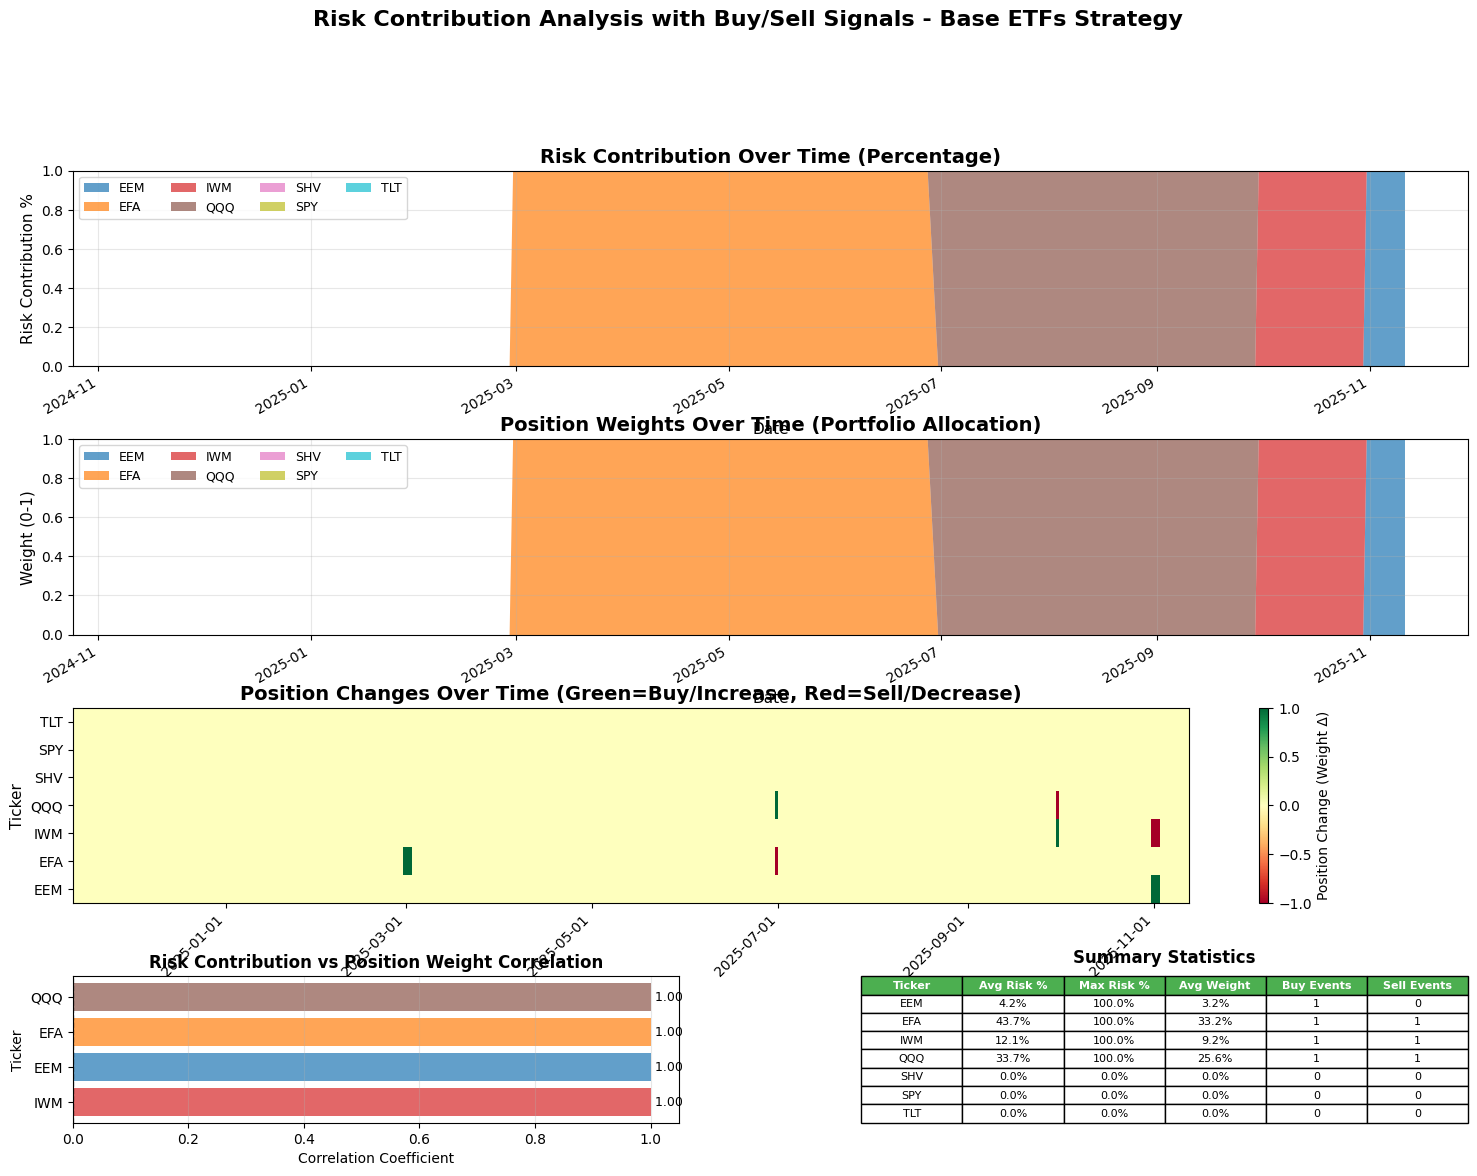


RISK CONTRIBUTION ANALYSIS - ACTIONABLE INSIGHTS

📊 INTERPRETATION GUIDE:
--------------------------------------------------------------------------------
1. RISK CONTRIBUTION: Shows how much each ticker contributes to portfolio risk
   - High risk contribution = ticker is driving portfolio volatility
   - Low risk contribution = ticker is stabilizing the portfolio

2. POSITION WEIGHTS: Shows actual portfolio allocation
   - Weight = 1.0 (100%) = fully allocated to that ticker
   - Weight = 0.0 = not holding that ticker

3. POSITION CHANGES (Buy/Sell Signals):
   - GREEN areas = BUY/INCREASE position (weight going up)
   - RED areas = SELL/DECREASE position (weight going down)
   - This shows when the strategy rotates between tickers

4. RISK vs POSITION CORRELATION:
   - Positive correlation = risk increases when position increases (expected)
   - Negative correlation = risk decreases when position increases (unusual)

💡 TRADING SIGNALS:
----------------------------------------------

In [47]:
RiskContributionAnalyzer().plot(results_base)

from risk_contribution_visualization import plot_risk_contribution_with_signals

# Run the enhanced analysis
plot_risk_contribution_with_signals(results_broad, title="Risk Contribution Analysis with Buy/Sell Signals - Base ETFs Strategy")

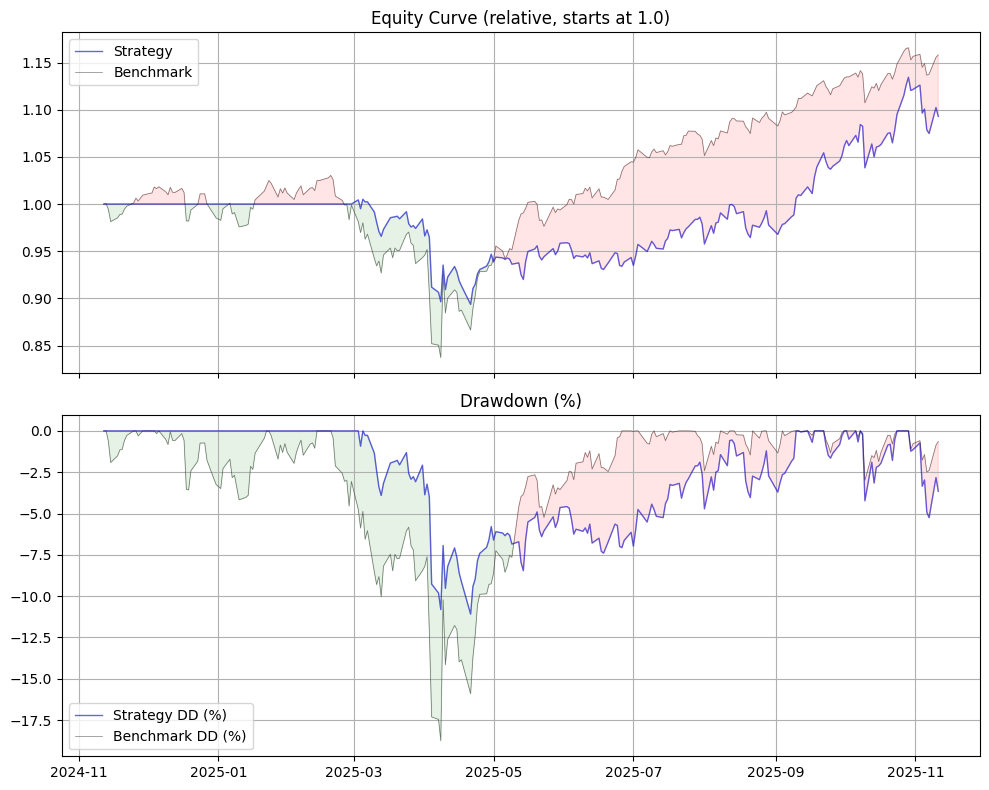

In [48]:
strategy = GlobalMarketRotationStrategy(
    tickers=sector_etfs,
    lookback_days=63,
)
results_sector = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_sector)

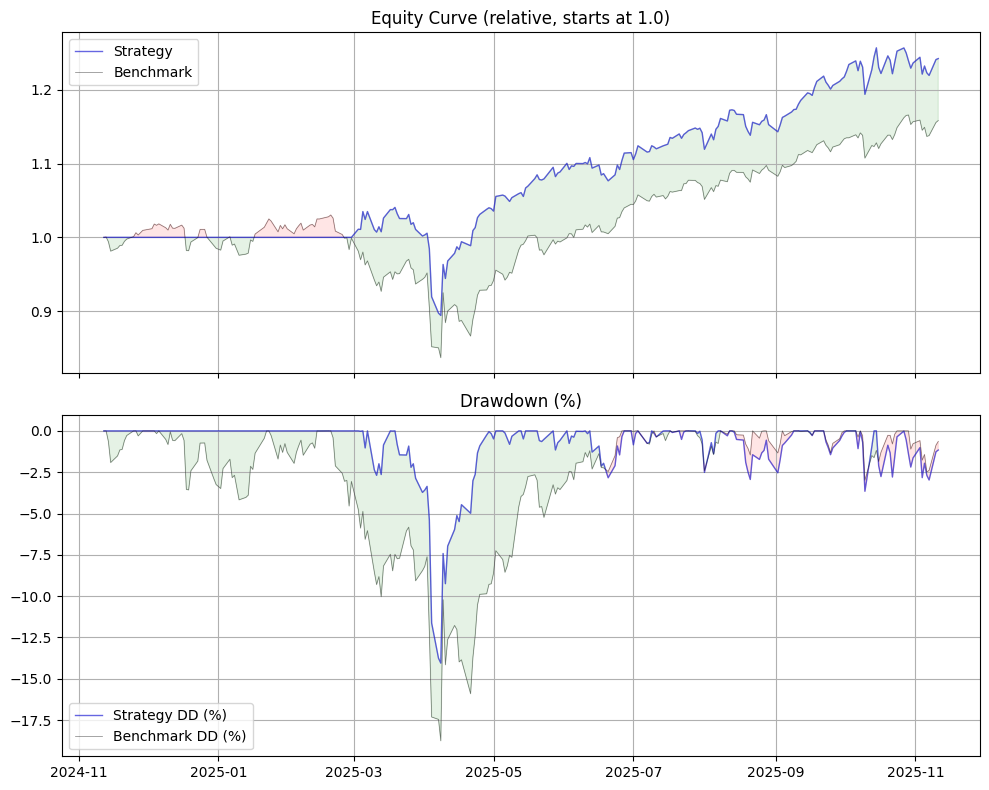

In [49]:
strategy = GlobalMarketRotationStrategy(
    tickers=broad_etfs,
    lookback_days=63,
)
results_broad = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_broad)

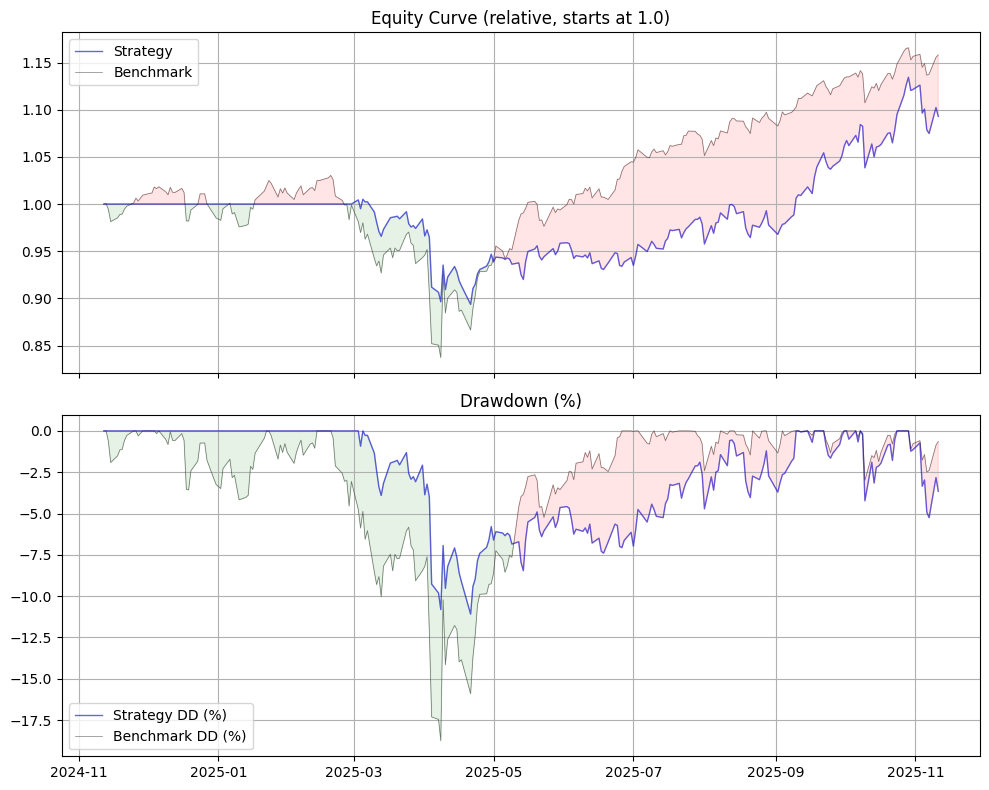

In [50]:
strategy = GlobalMarketRotationStrategy(
    tickers=sector_etfs,
    lookback_days=63,
)
results = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results)

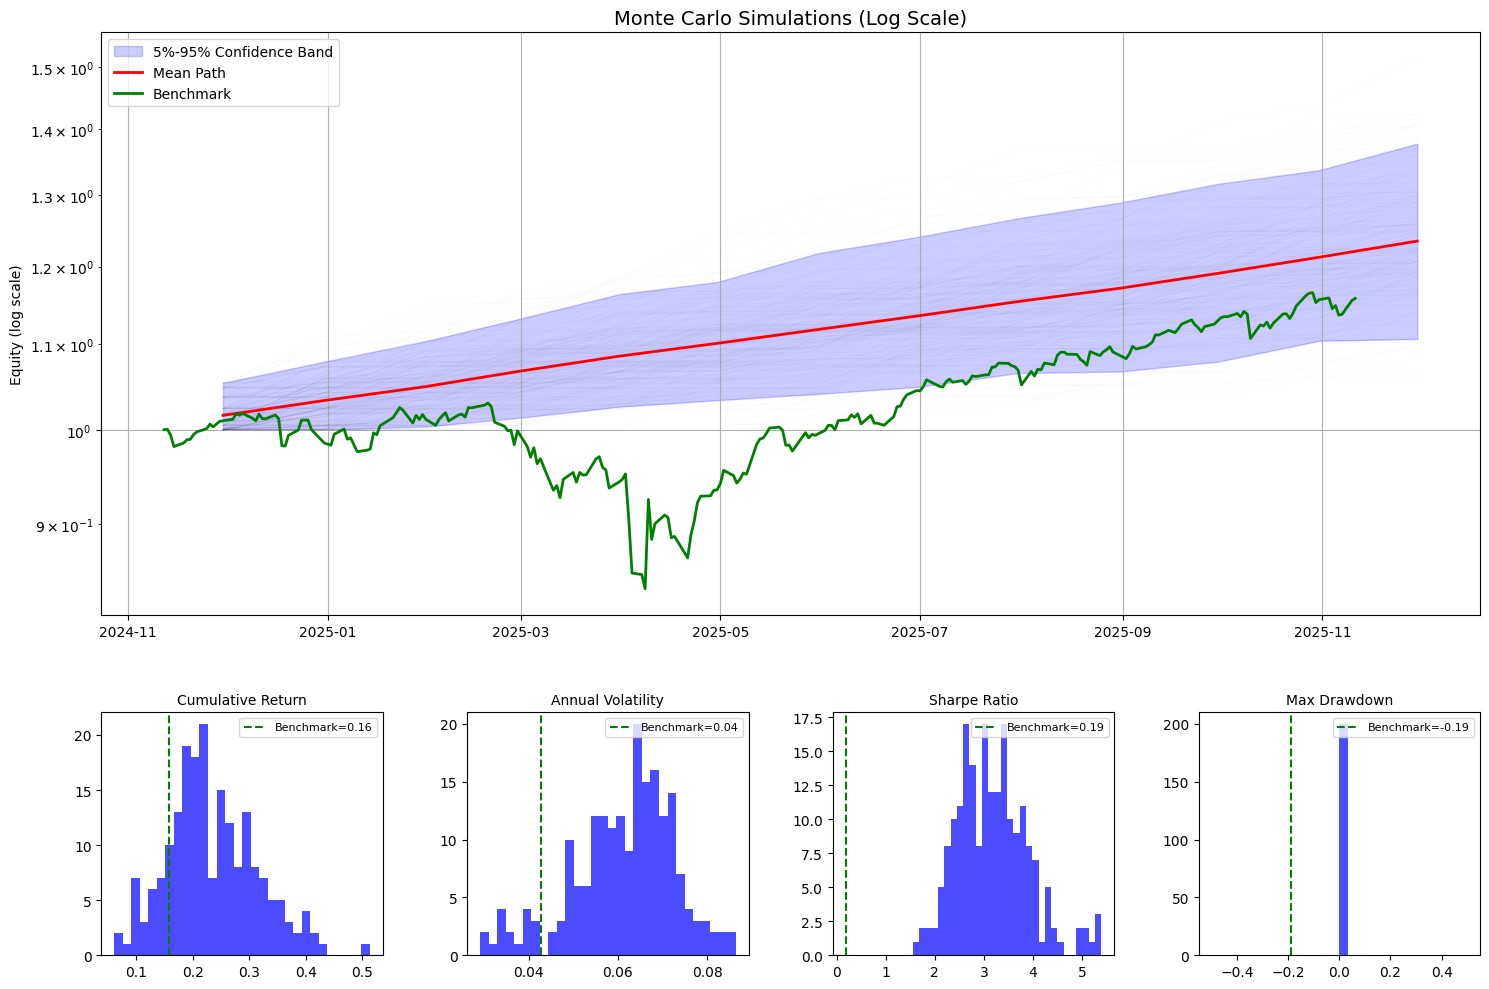

In [51]:
MonteCarloAnalyzer().plot(results_broad)

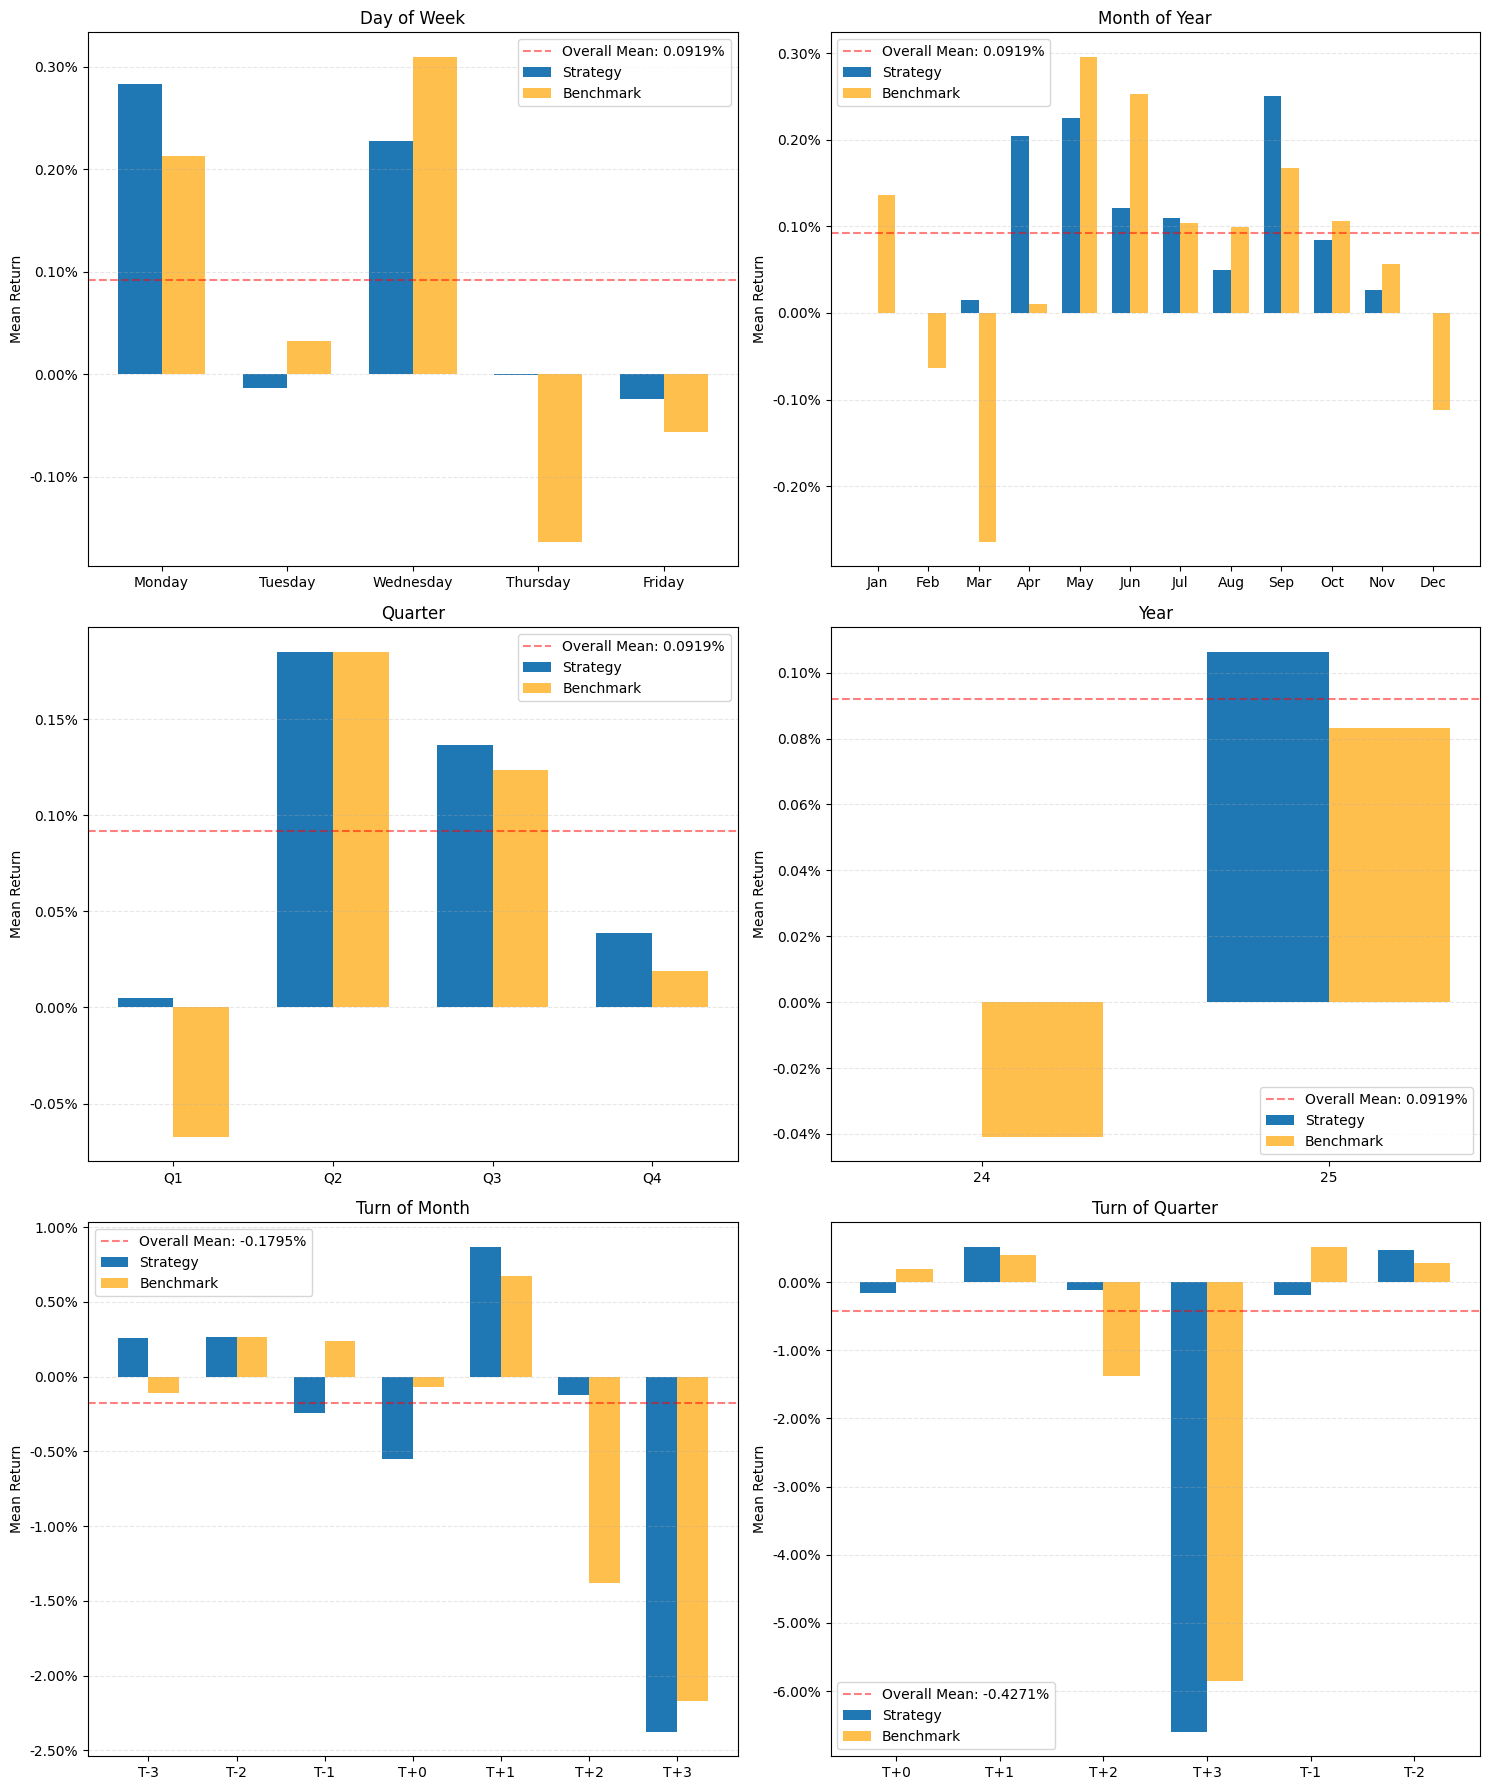

In [52]:
SeasonalityAnalyzer().plot(results_broad)

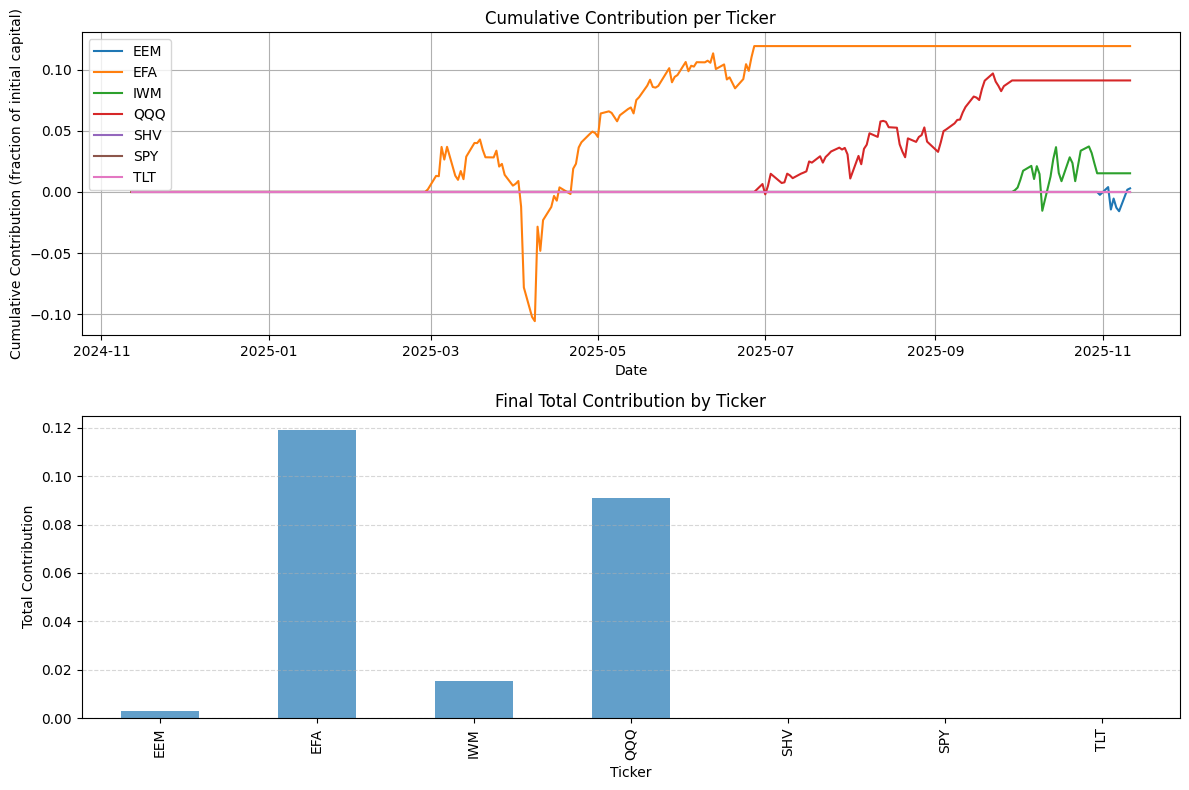

In [53]:
## Paid-subscriber Analyzer
PerformanceAttributionAnalyzer().plot(results_broad)

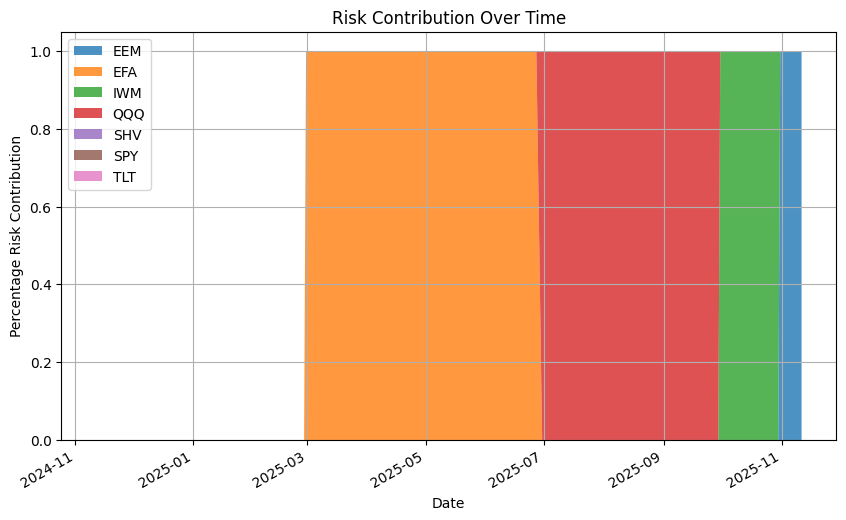

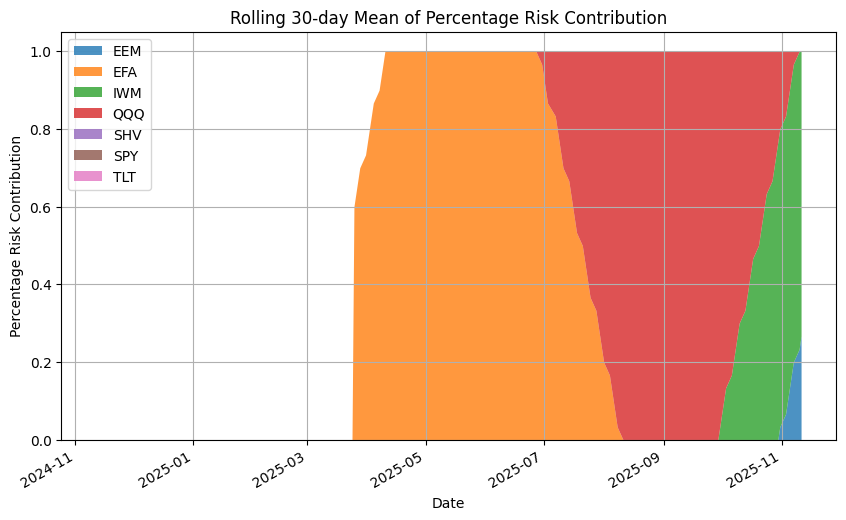

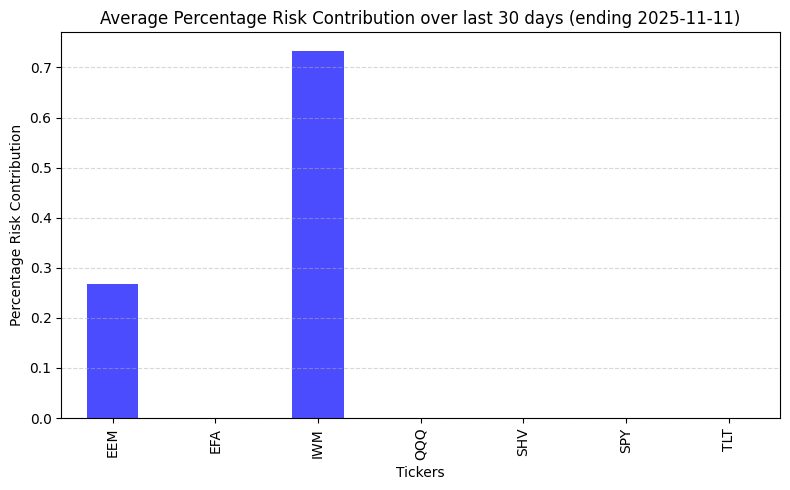

/Users/poboisvert/Desktop/GIT/portwine/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/poboisvert/Desktop/GIT/portwine/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/poboisvert/Desktop/GIT/portwine/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/poboisvert/Desktop/GIT/portwine/examples/risk_contribution_visualization.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


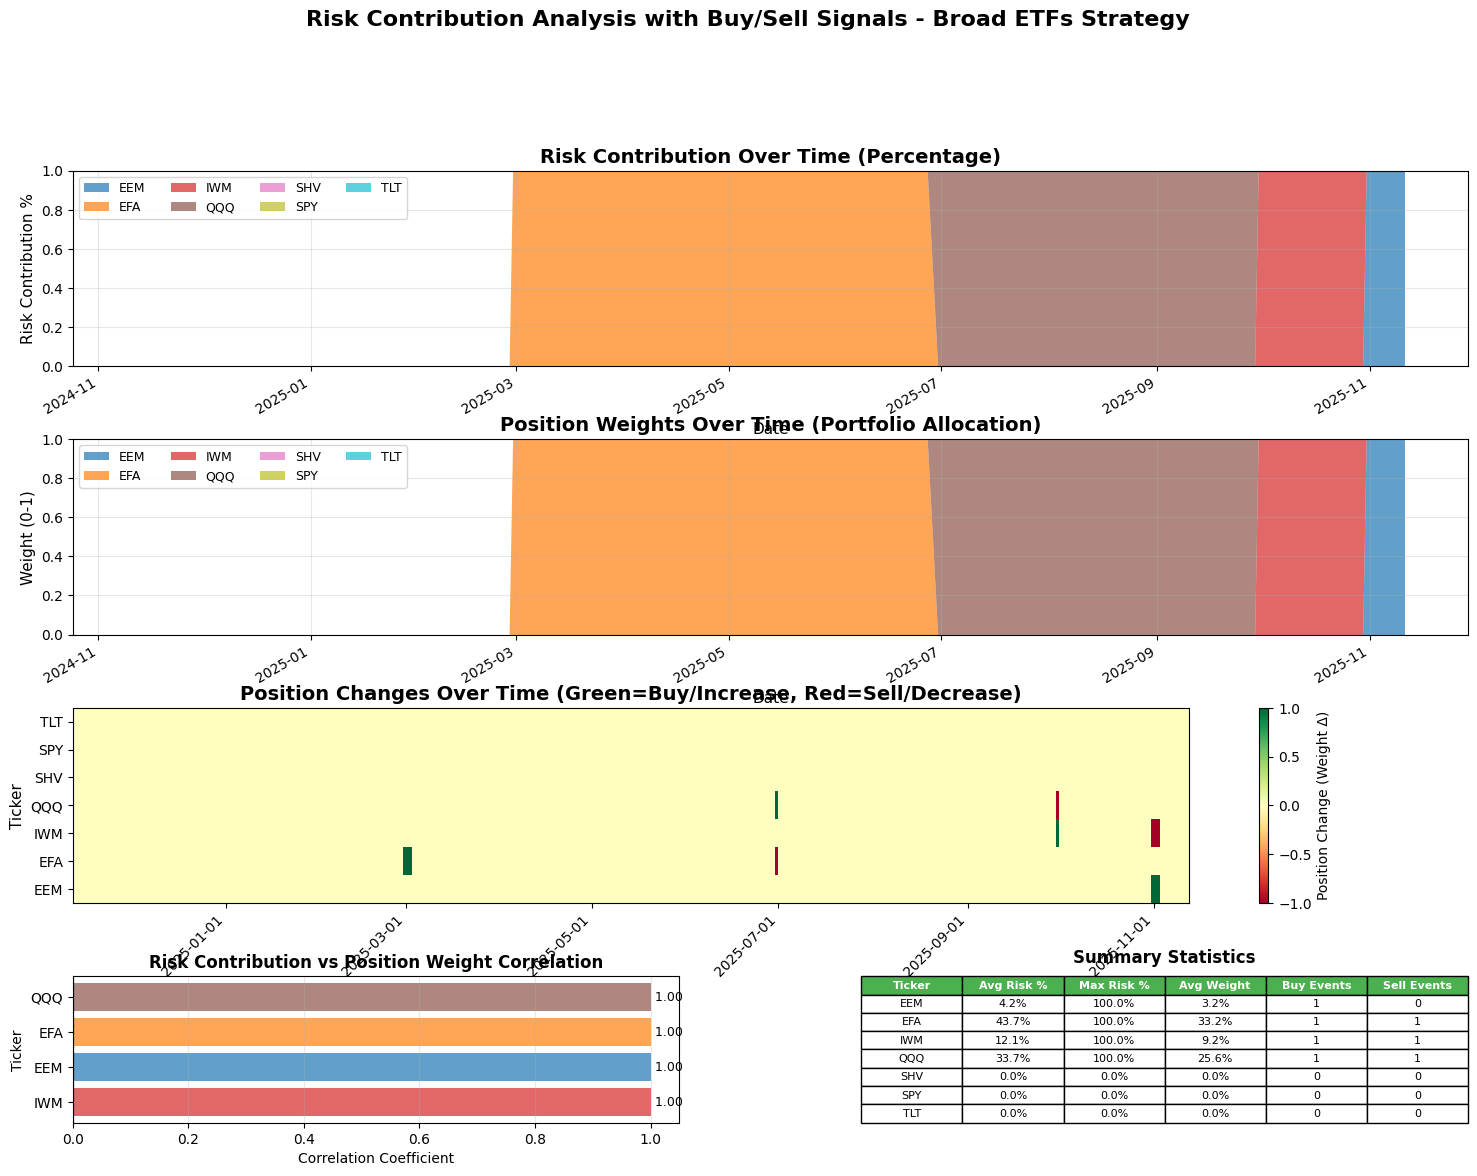


RISK CONTRIBUTION ANALYSIS - ACTIONABLE INSIGHTS

📊 INTERPRETATION GUIDE:
--------------------------------------------------------------------------------
1. RISK CONTRIBUTION: Shows how much each ticker contributes to portfolio risk
   - High risk contribution = ticker is driving portfolio volatility
   - Low risk contribution = ticker is stabilizing the portfolio

2. POSITION WEIGHTS: Shows actual portfolio allocation
   - Weight = 1.0 (100%) = fully allocated to that ticker
   - Weight = 0.0 = not holding that ticker

3. POSITION CHANGES (Buy/Sell Signals):
   - GREEN areas = BUY/INCREASE position (weight going up)
   - RED areas = SELL/DECREASE position (weight going down)
   - This shows when the strategy rotates between tickers

4. RISK vs POSITION CORRELATION:
   - Positive correlation = risk increases when position increases (expected)
   - Negative correlation = risk decreases when position increases (unusual)

💡 TRADING SIGNALS:
----------------------------------------------

In [54]:
## Paid-subscriber Analyzer - Enhanced with Buy/Sell Signals
# First show the standard risk contribution analysis
RiskContributionAnalyzer().plot(results_broad)

from risk_contribution_visualization import plot_risk_contribution_with_signals

# Run the enhanced analysis
plot_risk_contribution_with_signals(results_broad, title="Risk Contribution Analysis with Buy/Sell Signals - Broad ETFs Strategy")

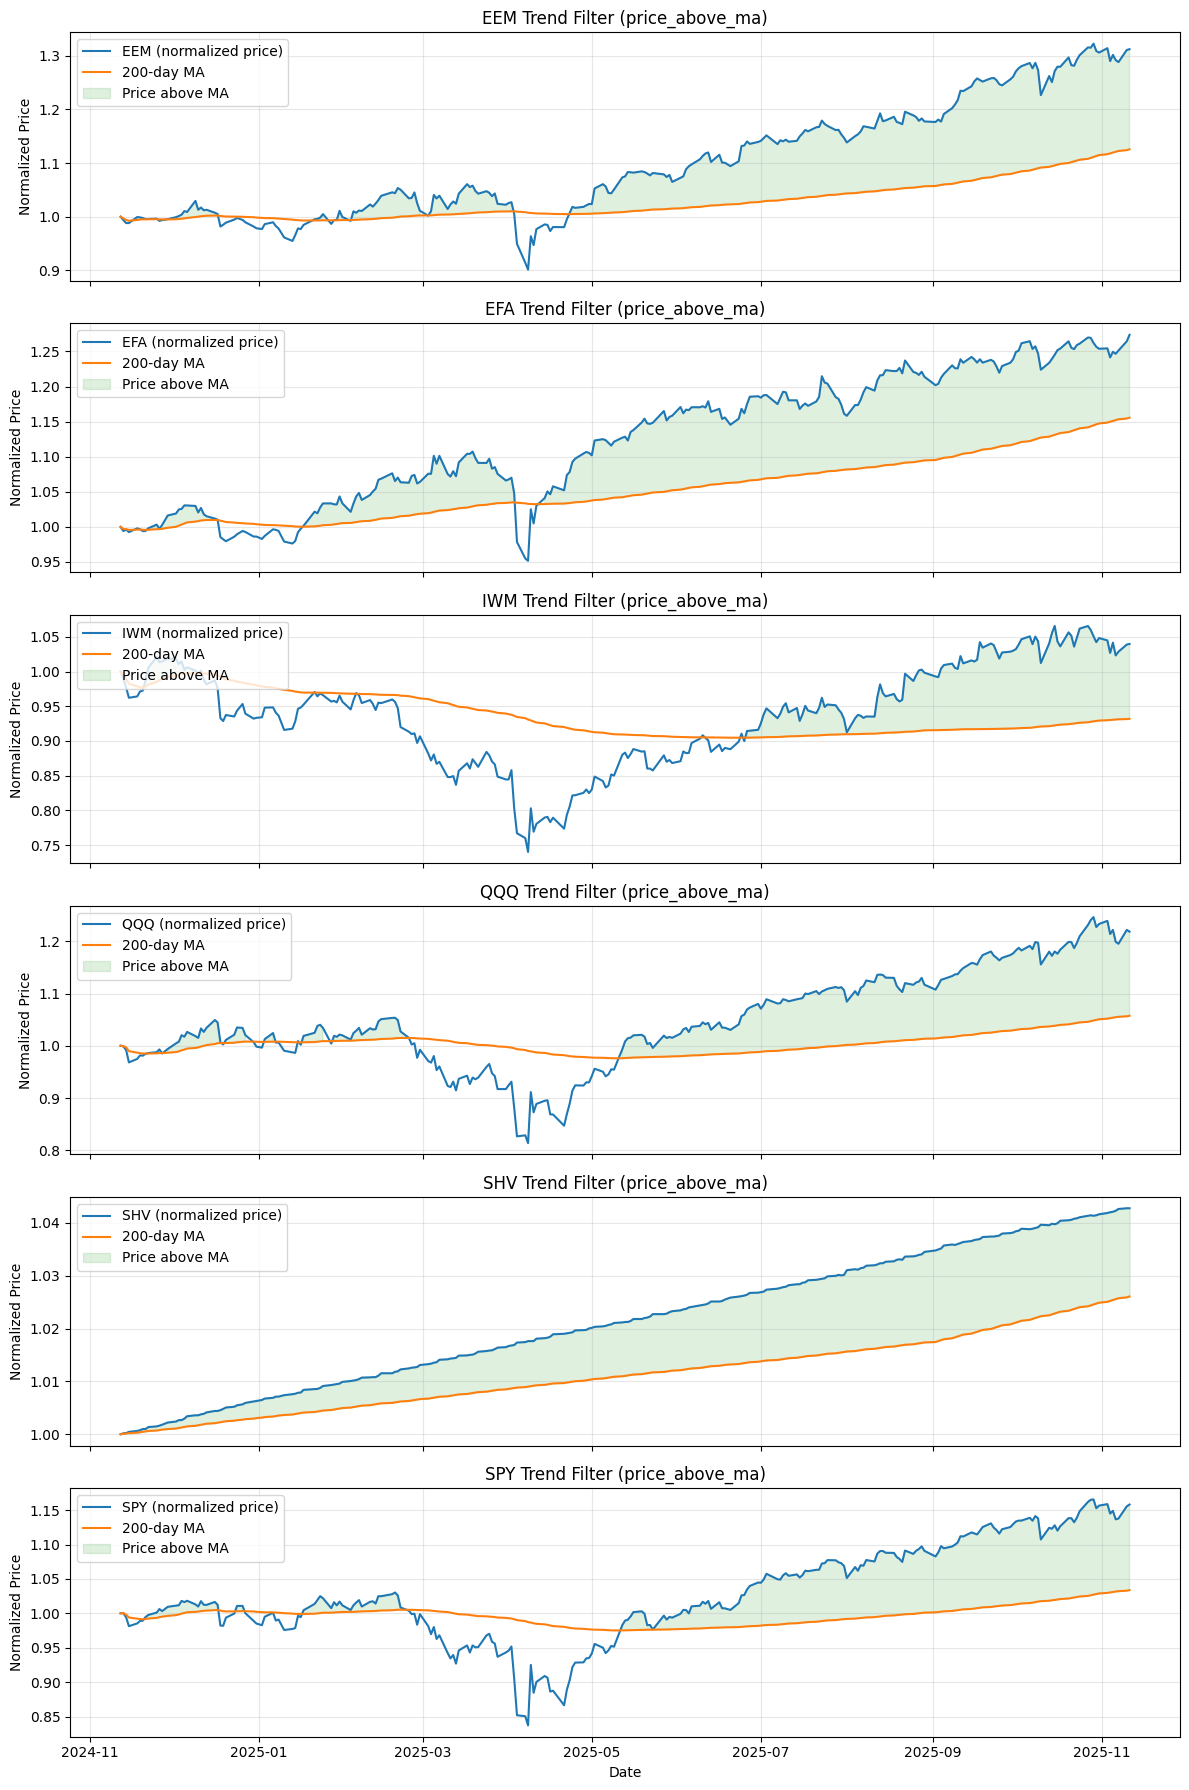

In [55]:
## Paid-subscriber Analyzer
TrendFilterAnalyzer(filter_type='price_above_ma').plot(results_broad)

In [56]:
commodity_etfs = ["GLD", "SLV", "USO", "DBA", "TLT", "SHY"]
stocks_basket = ["AAPL", "TSLA", "XOM", "JNJ", "TLT", "BIL"]
extended_sectors = ["XLF", "XLE", "XLK", "XLY", "XLP", "XLV", "XLI", "XLB", "XLU", "TLT", "SHY"]

bonus_vanguard = ["VTI", "VEA", "VWO", "BND", "BIV", "VGSH"]
bonus_spdr_w_gold = ["SPY","MDY","SPEM","SPDW","GLD","ITE","BIL"]

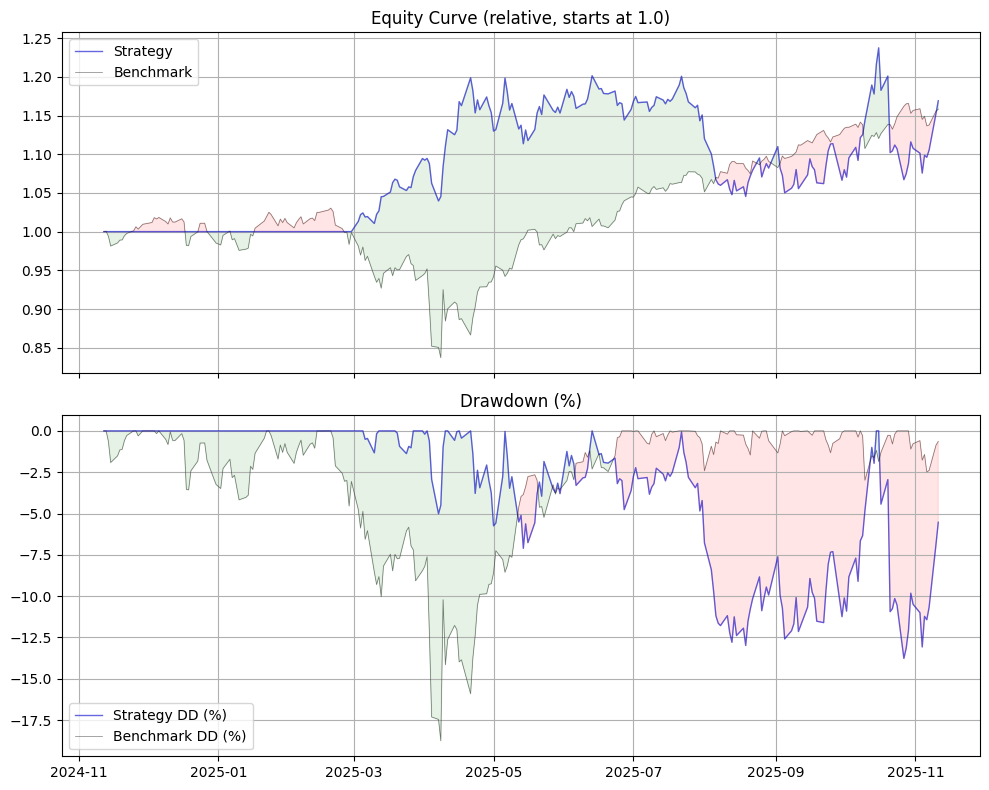

In [57]:
strategy = GlobalMarketRotationStrategy(
    tickers=commodity_etfs,
    lookback_days=63,
)
results_commodity = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_commodity)

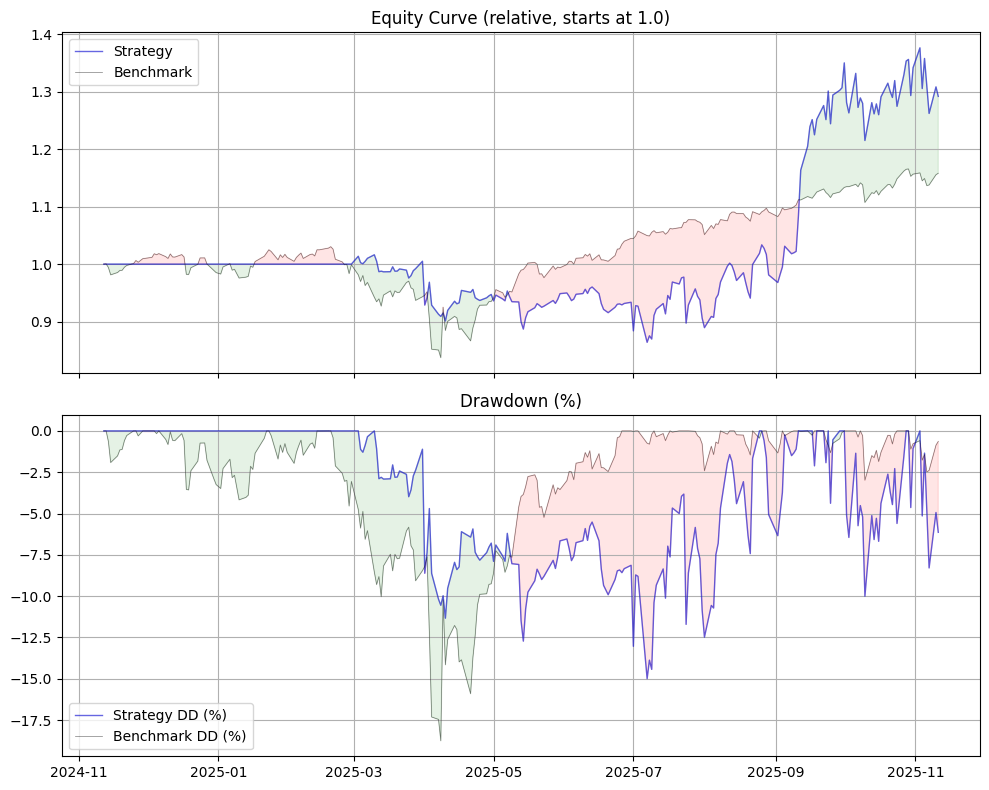

In [58]:
strategy = GlobalMarketRotationStrategy(
    tickers=stocks_basket,
    lookback_days=63,
)
results_stocks = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_stocks)

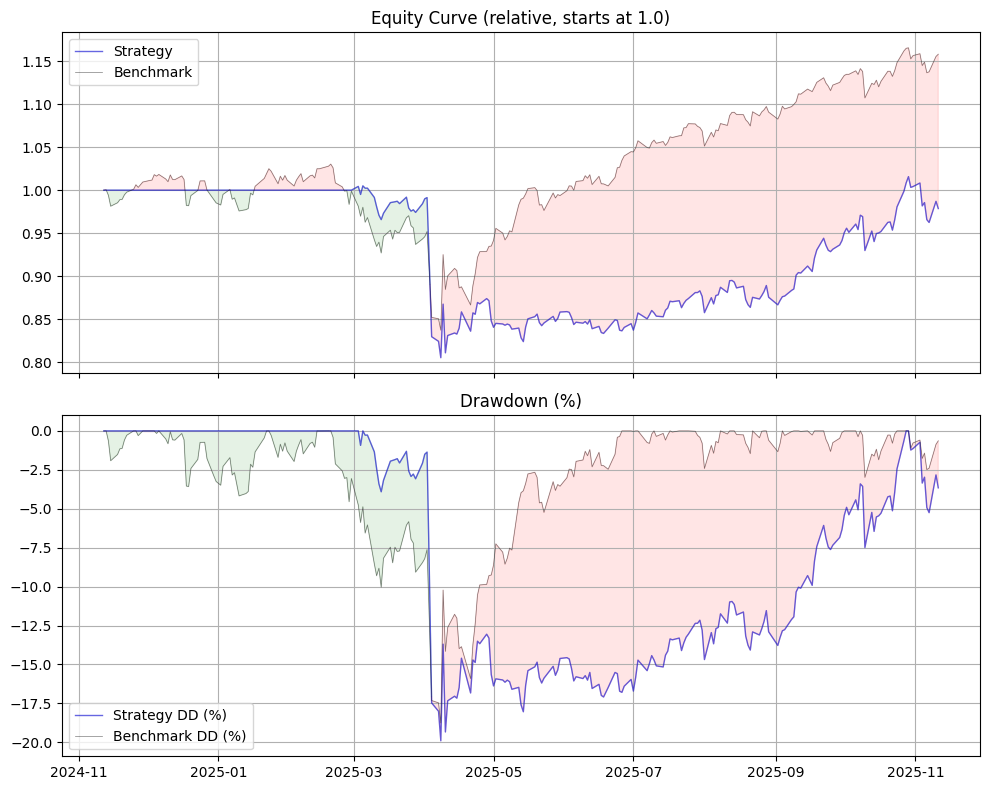

In [59]:
strategy = GlobalMarketRotationStrategy(
    tickers=extended_sectors,
    lookback_days=63,
)
results_extended = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_extended)

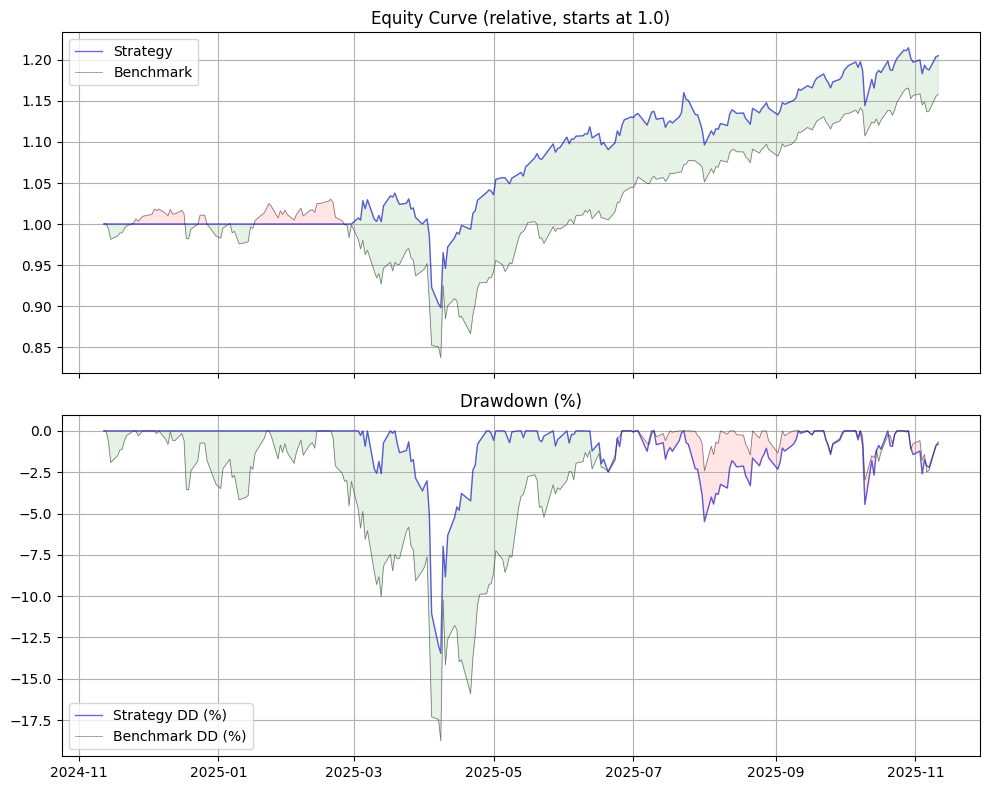

In [60]:
strategy = GlobalMarketRotationStrategy(
    tickers=bonus_vanguard,
    lookback_days=63,
)
results_vanguard = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_vanguard)

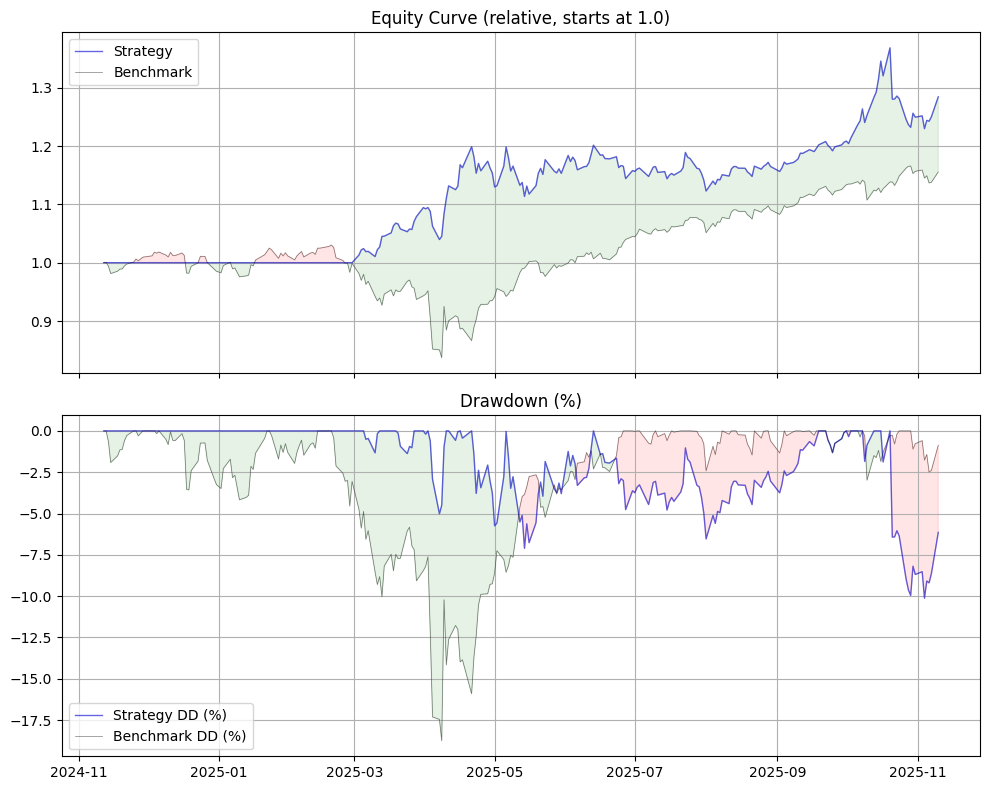

In [61]:
strategy = GlobalMarketRotationStrategy(
    tickers=bonus_spdr_w_gold,
    lookback_days=63,
)
results_spdr = backtester.run_backtest(strategy, benchmark="SPY")

EquityDrawdownAnalyzer().plot(results_spdr)

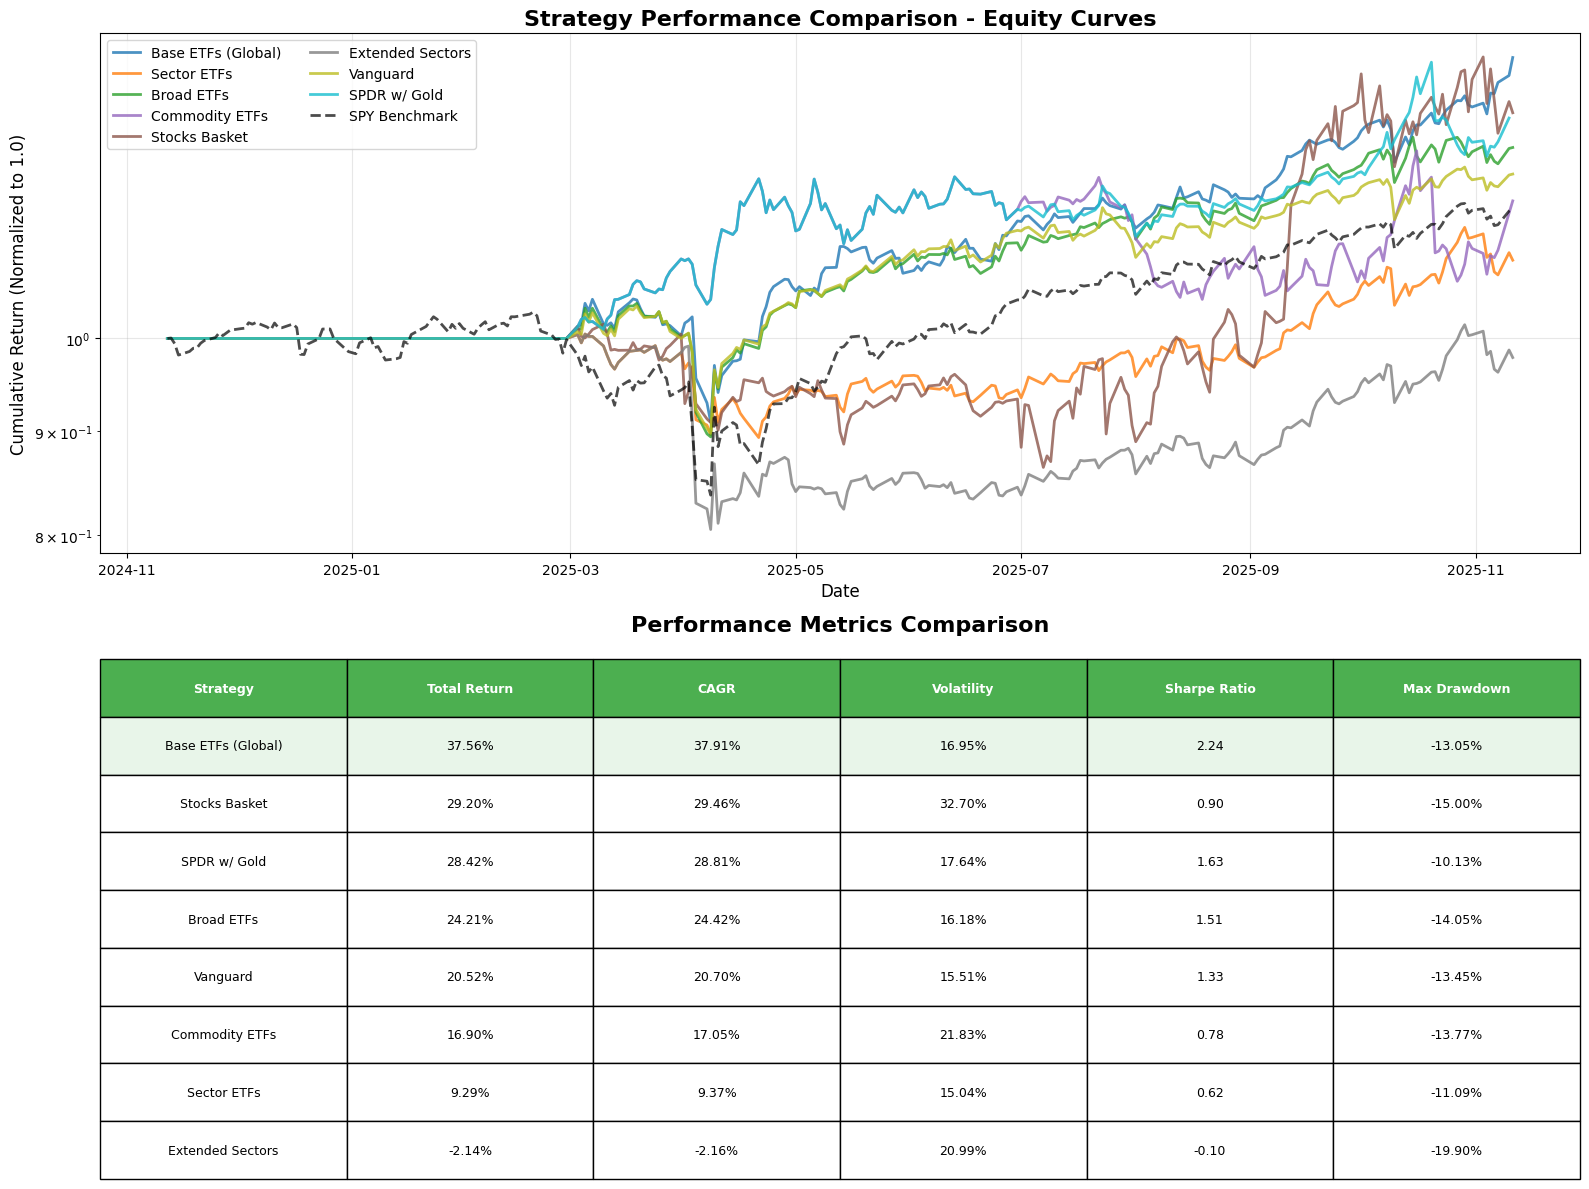


STRATEGY PERFORMANCE SUMMARY

Best Performing Strategy (by CAGR): Base ETFs (Global)
  CAGR: 37.91%
  Total Return: 37.56%
  Sharpe Ratio: 2.24
  Max Drawdown: -13.05%



In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Collect all results
all_results = {
    'Base ETFs (Global)': results_base,
    'Sector ETFs': results_sector,
    'Broad ETFs': results_broad,
    'Commodity ETFs': results_commodity,
    'Stocks Basket': results_stocks,
    'Extended Sectors': results_extended,
    'Vanguard': results_vanguard,
    'SPDR w/ Gold': results_spdr,
}

# Calculate equity curves for all strategies
equity_curves = {}
for name, results in all_results.items():
    if 'strategy_returns' in results and results['strategy_returns'] is not None:
        strategy_returns = results['strategy_returns']
        equity_curve = (1 + strategy_returns).cumprod()
        equity_curves[name] = equity_curve

# Also get benchmark if available
benchmark_curve = None
if 'benchmark_returns' in results_base and results_base['benchmark_returns'] is not None:
    benchmark_returns = results_base['benchmark_returns']
    benchmark_curve = (1 + benchmark_returns).cumprod()

# Create comparison chart
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Equity Curves
colors = plt.cm.tab10(np.linspace(0, 1, len(equity_curves)))
for i, (name, equity) in enumerate(equity_curves.items()):
    ax1.plot(equity.index, equity.values, label=name, linewidth=2, color=colors[i], alpha=0.8)

# Add benchmark
if benchmark_curve is not None:
    ax1.plot(benchmark_curve.index, benchmark_curve.values, 
             label='SPY Benchmark', linewidth=2, color='black', linestyle='--', alpha=0.7)

ax1.set_title('Strategy Performance Comparison - Equity Curves', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Cumulative Return (Normalized to 1.0)', fontsize=12)
ax1.legend(loc='best', fontsize=10, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')  # Log scale for better visualization

# Plot 2: Performance Metrics Table
metrics_data = []
for name, results in all_results.items():
    if 'strategy_returns' in results and results['strategy_returns'] is not None:
        returns = results['strategy_returns']
        if len(returns) > 0:
            total_return = (1 + returns).prod() - 1
            annual_return = (1 + total_return) ** (252 / len(returns)) - 1
            annual_vol = returns.std() * np.sqrt(252)
            sharpe = annual_return / annual_vol if annual_vol > 0 else 0
            
            # Max drawdown
            equity = (1 + returns).cumprod()
            running_max = equity.expanding().max()
            drawdown = (equity - running_max) / running_max
            max_dd = drawdown.min()
            
            metrics_data.append({
                'Strategy': name,
                'Total Return': f"{total_return*100:.2f}%",
                'CAGR': f"{annual_return*100:.2f}%",
                'Volatility': f"{annual_vol*100:.2f}%",
                'Sharpe Ratio': f"{sharpe:.2f}",
                'Max Drawdown': f"{max_dd*100:.2f}%"
            })

# Create metrics DataFrame
metrics_df = pd.DataFrame(metrics_data)
# Sort by CAGR (extract numeric value for sorting)
if len(metrics_df) > 0:
    metrics_df['CAGR_numeric'] = metrics_df['CAGR'].str.rstrip('%').astype(float)
    metrics_df = metrics_df.sort_values('CAGR_numeric', ascending=False)
    metrics_df = metrics_df.drop('CAGR_numeric', axis=1)

# Display table
ax2.axis('tight')
ax2.axis('off')
table = ax2.table(cellText=metrics_df.values,
                  colLabels=metrics_df.columns,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style the header
for i in range(len(metrics_df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best performers
for i in range(1, len(metrics_df) + 1):
    if i == 1:  # Best CAGR
        for j in range(len(metrics_df.columns)):
            table[(i, j)].set_facecolor('#E8F5E9')

ax2.set_title('Performance Metrics Comparison', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("STRATEGY PERFORMANCE SUMMARY")
print("="*80)
print(f"\nBest Performing Strategy (by CAGR): {metrics_df.iloc[0]['Strategy']}")
print(f"  CAGR: {metrics_df.iloc[0]['CAGR']}")
print(f"  Total Return: {metrics_df.iloc[0]['Total Return']}")
print(f"  Sharpe Ratio: {metrics_df.iloc[0]['Sharpe Ratio']}")
print(f"  Max Drawdown: {metrics_df.iloc[0]['Max Drawdown']}")
print("\n" + "="*80)
